Import des différentes librairies

In [1]:
#import pixiedust
import tweepy
import squarify 
from geopy.geocoders import Nominatim
import folium
import json_lines
import json
import time
import datetime
import random
import itertools
import os
import matplotlib.pyplot as plt

# pip install tweepy json_lines squarify folium geopy

In [19]:
count_tweets = 1                                         # Number of tweets returned
keyword = "holiday"                                      # Keyword
language = "en"                                          # Language, must be ISO 639-1 code
since = None                                             # Start date
until = datetime.datetime.now().strftime("%Y-%m-%d")     # End date
result_type = "recent"                                   # recent, popular, or mixed
geocode = None                                           # Geocode

Configuration du nom du fichier utilisé

In [20]:
%env TIME={time.time()}
%env OUTPUT_TWEET_FILENAME=output_tweet_{os.environ['TIME']}.json
%env TWEET_JSON_FILENAME=input_tweet_{os.environ['TIME']}.json


env: TIME=1521703911.726757
env: OUTPUT_TWEET_FILENAME=output_tweet_1521703911.726757.json
env: TWEET_JSON_FILENAME=input_tweet_1521703911.726757.json


In [21]:
with_geo=False
API_key = json.load(open("API_key.txt", "r"))

auth = tweepy.OAuthHandler(API_key["consumer_key"], API_key["consumer_secret"])
auth.set_access_token(API_key["access_token"], API_key["access_token_secret"])
api = tweepy.API(auth)

tweets = api.search(q=keyword, 
                    until=until, 
                    since=since, 
                    count=count_tweets, 
                    language=language, 
                    result_type=result_type, 
                    geocode=geocode
                   )

tweets = api.search( q=keyword,tweet_mode='extended',include_rts=False,count=2000)

json_tweets=[]
for tweet in tweets:
    json_tweets.append(json.dumps(tweet._json))

json_str = "\n".join(json_tweets)

filename = "tweets-database/"+os.environ['TWEET_JSON_FILENAME']
with open(filename, "w") as f:
    f.write(json_str)

Envoie des tweets collectés sur le datacenter et lancement de l'analyse

In [22]:
%%bash
cp tweets-database/$TWEET_JSON_FILENAME Algo1/$TWEET_JSON_FILENAME
cd Algo1
sbt "put $TWEET_JSON_FILENAME"
rm -rf $TWEET_JSON_FILENAME
sbt "submit $TWEET_JSON_FILENAME"
sbt "getOutput 'defaultoutput.json'"
cp defaultoutput.json ../tweets-database/$OUTPUT_TWEET_FILENAME
rm -rf defaultoutput.json

[info] Loading settings from idea.sbt ...
[info] Loading global plugins from /Users/Frego/.sbt/1.0/plugins
[info] Loading settings from plugins.sbt ...
[info] Loading project definition from /Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/project
[info] Loading settings from build.sbt ...
[info] Set current project to SparkSenti (in build file:/Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/)
spawn scp input_tweet_1521703911.726757.json fregosi1@sparksenti:.
fregosi1@sparksenti's password: 
input_tweet_1521703911.726757.json            100%  511KB   4.7MB/s   00:00    
spawn ssh fregosi1@sparksenti
fregosi1@sparksenti's password: 

Welcome to Bright release         7.3

                                                        Based on CentOS Linux 7
                                                                    ID: #000002

Use the following commands to adjust your environment:

'module avail'            - show available modules
'module add

Pour test de viz (evite de lancer le workflow complet)

In [8]:
#%env OUTPUT_TWEET_FILENAME=output_test.json
#%env TWEET_JSON_FILENAME=input_test.json

env: OUTPUT_TWEET_FILENAME=output_test.json
env: TWEET_JSON_FILENAME=input_test.json


In [17]:
file_json = open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'],"r", encoding="utf8");
reader = json_lines.reader(file_json)


In [18]:
geolocator = Nominatim(timeout=3)

WASH_COORD = [38.8949549, -77.0366456]
NYC_COORD = [40.7128, -74.0059]
LYON_COORD = [45.750000,4.850000]
CHICAGO_COORD = [41.850033, -87.6500523]
US_COORD = [39,-95]

# Build map 
map_main = folium.Map(location=US_COORD, 
                      zoom_start=4, 
                      tiles='cartodbpositron', 
                      width=640, 
                      height=400)



           #  ======> sert à limiter le nombre de tweets afficher sur la carte
#for tweet in itertools.islice(reader, 30):
#for tweet in reader :      # =======> sert à afficher tout les tweets

for tweet in itertools.islice(reader, 10):
    if (tweet['tweet']!= ''):
        location = geolocator.geocode(tweet['tweet']['user']['location'])
        popup_image ='''<img src="''' + tweet['tweet']['user']['profile_image_url'] + '''" alt="pic " />'''
        popup_text = '<b>'+tweet['tweet']['user']['name']+'</b>' + ' tweeted : '+ '<i>' + tweet['tweet']['full_text'] + '</i>'
        popup = '<center>' + popup_image + '<br\><br\>' + popup_text + '</center>'
        location = [location.latitude + random.gauss(0,0000.1), location.longitude + random.gauss(0,000.1)]
        if tweet['result'] == 'Positif':
            folium.Marker(location,                               
                          popup= popup,
                          #popup= folium.Popup(test, max_width=2650),
                          icon=folium.Icon(color='green')
                         ).add_to(map_main)
        elif tweet['result'] == 'Negatif':
            folium.Marker(location,   
                          popup= popup,
                          icon=folium.Icon(color='red')
                         ).add_to(map_main)            
        elif tweet['result'] == 'Neutre':
            folium.Marker(location,   
                          popup= popup,
                          icon=folium.Icon(color='lightgray')
                         ).add_to(map_main)                    




# Display map in Jupyter
map_main

GeocoderServiceError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:749)

Treemap chart

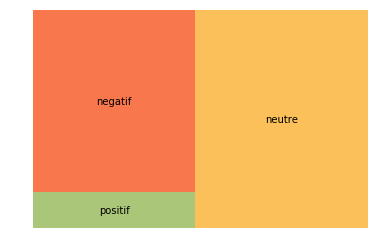

In [23]:
y=[0,0,0];
with open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'], 'rb') as f:
    for tweet in json_lines.reader(f):
        if tweet['result'] == 'Positif':
            y[0]+=1
        elif tweet['result'] == 'Negatif':
            y[1]+=1
        elif tweet['result'] == 'Neutre':
            y[2]+=1
x=["positif","negatif","neutre"]; 
colors=["#87AF41","#F63E02","#FAA613"];
if 0 in y:
    k=y.index(0)
    del x[k]
    del y[k]
    del colors[k]
if 0 in y:
    k=y.index(0)
    del x[k]
    del y[k]
    del colors[k]
squarify.plot(sizes=y, label=x, alpha=.7 ,color=colors)
plt.axis('off')
plt.show()

Liste des tweets

In [64]:
from tabulate import tabulate
from texttable import Texttable
data=[["Score","Tweet"]]
with open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'], 'rb') as f:
    for tweet in json_lines.reader(f):
        data.append([tweet["result"],tweet["tweet"]["full_text"]])
        
#print(tabulate(data, headers=['Score', 'Tweet']))




t = Texttable()
t.add_rows([['Name', 'Age'], ['Alice', 24], ['Bob', 19]])
print (t.draw())

+-------+-----+
| Name  | Age |
+=======+=====+
| Alice | 24  |
+-------+-----+
| Bob   | 19  |
+-------+-----+


In [62]:
%%bash
echo $TIME

1521703911.726757
